In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
import random
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,MaxPooling2D,Dropout,InputLayer
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.applications import MobileNetV3Large
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.colors import LinearSegmentedColormap
import os
import cv2
import math
from imblearn.over_sampling import RandomOverSampler

In [2]:
directory='./Belgium_Datasets'
train_dir=directory+'/BelgiumTSC_Training/Training'
test_dir=directory+'/BelgiumTSC_Testing/Testing'
trainclasses=os.listdir(train_dir)
testclasses=os.listdir(test_dir)

In [3]:
print(trainclasses)

['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042', '00043', '00044', '00045', '00046', '00047', '00048', '00049', '00050', '00051', '00052', '00053', '00054', '00055', '00056', '00057', '00058', '00059', '00060', '00061']


In [4]:
df=[[]]
df=pd.DataFrame(df)
for i in trainclasses:
    path = "./Belgium_Datasets/BelgiumTSC_Training/Training/"+i+"/GT-"+i+".csv"
    df1 = pd.read_csv(path,sep=';')
    df1['Filename']="./Belgium_Datasets/BelgiumTSC_Training/Training/"+i+'/'+df1["Filename"]
    df=pd.concat([df,df1],ignore_index=True)

df['Rotate']=0
df["length"] = df["Roi.X2"]-df["Roi.X1"]
df["height"] = df["Roi.Y2"]-df["Roi.Y1"]
df=df.dropna()
df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate,length,height
1,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,141.0,142.0,12.0,12.0,128.0,130.0,0.0,0,116.0,118.0
2,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,120.0,123.0,10.0,10.0,109.0,113.0,0.0,0,99.0,103.0
3,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,105.0,107.0,9.0,9.0,96.0,98.0,0.0,0,87.0,89.0
4,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,94.0,105.0,8.0,9.0,86.0,95.0,0.0,0,78.0,86.0
5,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,128.0,139.0,11.0,12.0,117.0,127.0,0.0,0,106.0,115.0


In [5]:
df.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate,length,height
count,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.0,4591.000000,4591.000000
mean,124.844261,109.740362,10.558048,9.348508,113.778697,99.883032,34.005228,0.0,103.220649,90.534524
std,73.056649,60.209324,5.982332,4.860009,67.072788,55.385101,16.067205,0.0,61.111287,50.557826
min,22.000000,20.000000,5.000000,5.000000,16.000000,14.000000,0.000000,0.0,11.000000,9.000000
25%,79.000000,69.000000,7.000000,6.000000,71.000000,63.000000,22.000000,0.0,64.000000,57.000000
50%,107.000000,96.000000,9.000000,8.000000,97.000000,88.000000,37.000000,0.0,88.000000,80.000000
75%,151.000000,133.500000,13.000000,11.000000,137.000000,122.000000,46.000000,0.0,124.000000,111.000000
max,724.000000,529.000000,60.000000,44.000000,664.000000,484.000000,61.000000,0.0,604.000000,440.000000


In [6]:
num_of_classes = df["ClassId"].nunique()
resize_x  = 32
resize_y  = 32
num_of_channels = 3
directory = ""
Epochs=50
train_length = len(df)
Y_col_name="ClassId"

In [7]:
# Necessary Functions
def remove_outlier(df,parameter):
    Percentile25 = df[parameter].quantile(0.25)
    Percentile75 = df[parameter].quantile(0.75)
    iqr = Percentile75 - Percentile25
    lowerlimit = Percentile25 - 1.5*iqr
    upperlimit = Percentile75 + 1.5*iqr
    temp1 = df[parameter]>lowerlimit
    temp2 = df[parameter]<upperlimit
    return df[temp1 & temp2] 

def get_max_index(arr):
    length = len(arr)
    mini = 0
    value = 0
    for i,val in enumerate(arr):
        if mini < val :
            mini = val
            value = i
    return value

def viewStatistics(df):
    #Statistics of Data
    print("Total Training Examples : ",len(df))
    values = df["ClassId"].value_counts()
    x_labels = [str(x) for x in range(num_of_classes)]
    y_labels = []
    for x in range(num_of_classes):
        y_labels.append(values[x])
    plt.figure(figsize=(15, 6))
    plt.bar(x_labels,y_labels,width=0.5)
    plt.title('Bar Graph')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

def Predict_for_single_example(model,img):
    img  = np.array(img)
    img  = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    img = tf.expand_dims(img, axis=0)
    probability = model.predict(img)
    value = get_max_index(probability[0])
    return value
    
def Predict_for_Multiple_examples(model,images):
    img = []
    for j in range(len(images)):
        img.append(np.array(images[j]))
    img = np.array(img)
    img = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    probability = model.predict(img)
    values = []
    for val in probability:
        values.append(get_max_index(val))
    return values

def PredictTest(model,df,start,length):
    images = []
    y_test = []
    length = min(length,len(df)-start)
    for i in range(length):
        row = df.loc[start+i].values
        images.append(Image.open(directory+row[7]).crop((row[2],row[3],row[4],row[5])).resize((resize_x,resize_y)))
        y_test.append(row[6])
    

    y_predicted = Predict_for_Multiple_examples(model,images)

    return y_test,y_predicted

def PredictTest(model,df):
    images = []
    y_test = []
    length = len(df)
    for i in range(length):
        row = df.loc[i].values
        images.append(Image.open(directory+row[7]).crop((row[2],row[3],row[4],row[5])).resize((resize_x,resize_y)))
        y_test.append(row[6])
        
    y_predicted = Predict_for_Multiple_examples(model,images)

    return y_test,y_predicted

Total Training Examples :  4591


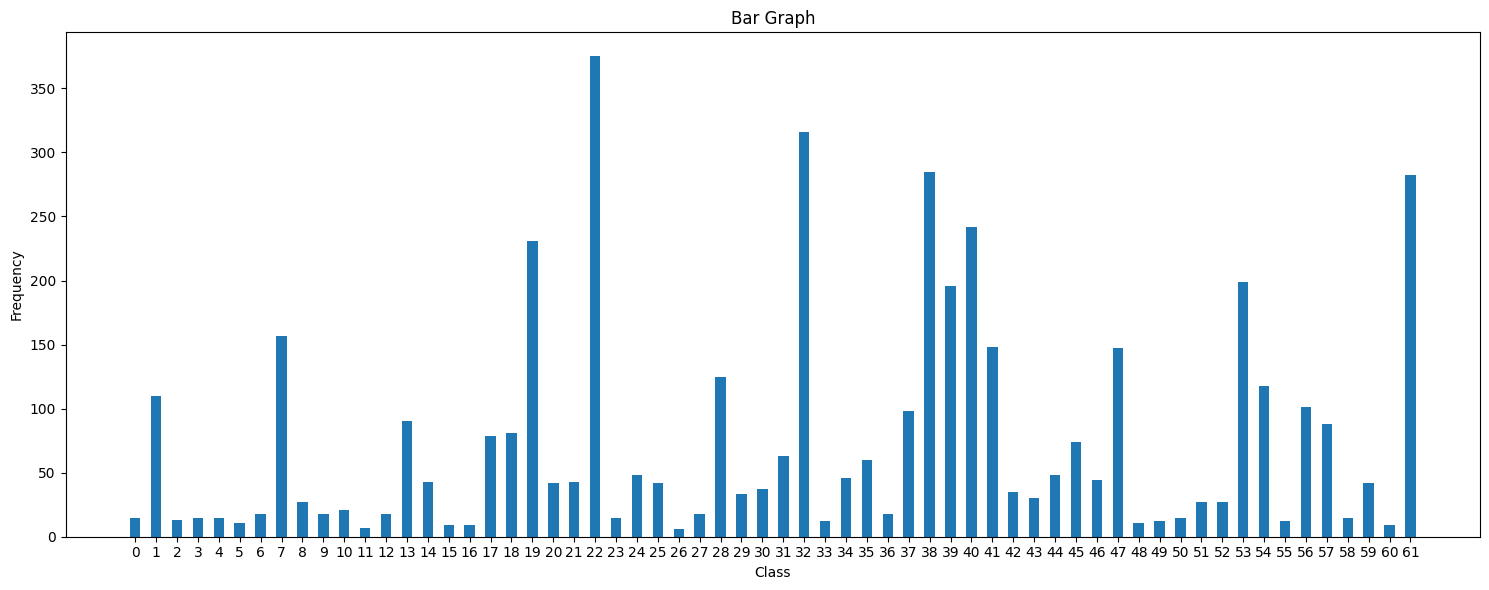

In [8]:
#Statistics of Data
viewStatistics(df)

In [9]:
train_length = len(df)
print("Total Training Examples : ",len(df))

Total Training Examples :  4591


Total Training Examples :  23250


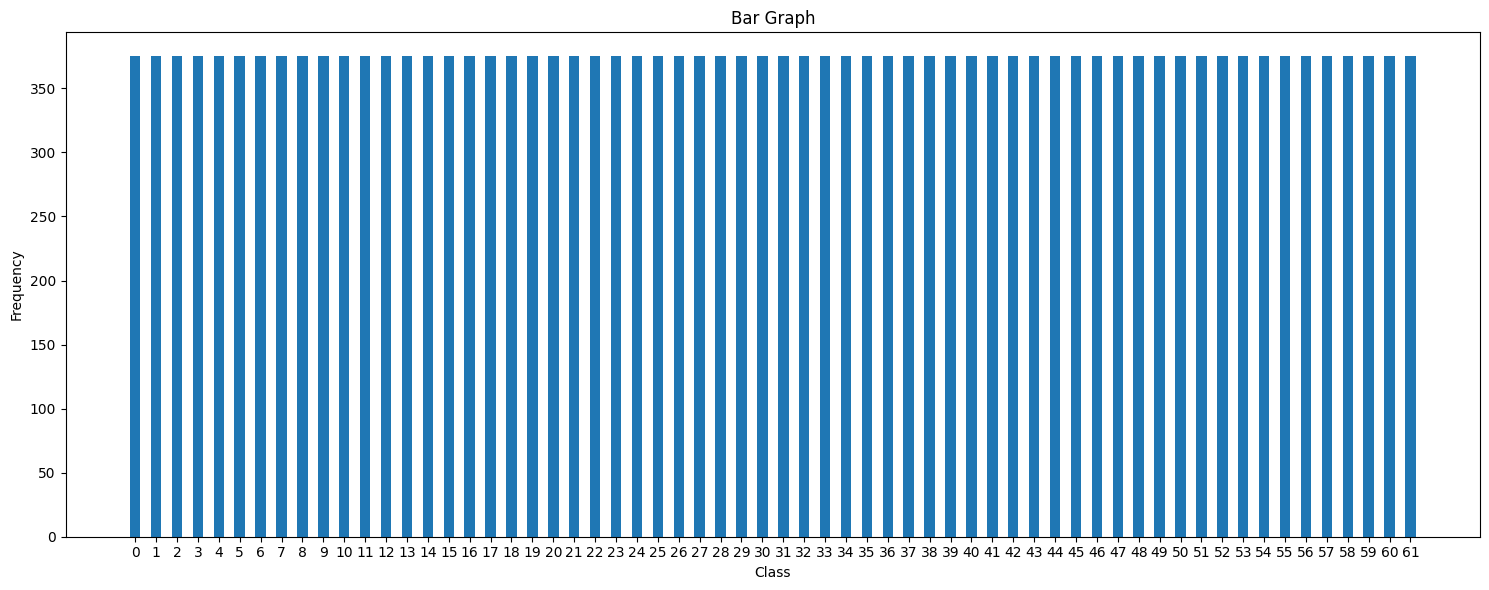

In [10]:
X = df.drop(Y_col_name, axis=1)
y = df[Y_col_name]
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Fit and apply the oversampler to the data
X_resampled, y_resampled = oversampler.fit_resample(X, y)

df = pd.DataFrame(X_resampled, columns=X.columns)
df[Y_col_name] = y_resampled
df[Y_col_name].astype(str)

viewStatistics(df)

In [11]:
df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,Rotate,length,height,ClassId
0,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,141.0,142.0,12.0,12.0,128.0,130.0,0,116.0,118.0,0.0
1,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,120.0,123.0,10.0,10.0,109.0,113.0,0,99.0,103.0,0.0
2,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,105.0,107.0,9.0,9.0,96.0,98.0,0,87.0,89.0,0.0
3,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,94.0,105.0,8.0,9.0,86.0,95.0,0,78.0,86.0,0.0
4,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,128.0,139.0,11.0,12.0,117.0,127.0,0,106.0,115.0,0.0


In [12]:
# Sample Images and there crop according to data given in csv
def showExamples(df):
    num_rows = 5
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
    total_images = []
    for i in range(5):
        integer = random.randint(0,len(df))
        total_images.append(df.iloc[integer].values)
    total_images = list(total_images)
    for i,val in enumerate(total_images):
        row = i
        col=0
        ax = axes[row, col]
        img = Image.open(directory+val[0])
        ax.imshow(img)
        img = img.crop((val[3],val[4],val[5],val[6]))
        ax = axes[row,col+1]
        ax.imshow(img)
        ax.set_title(directory+val[0])
        print(directory+val[0])
    ax.axis('off')

def showTestExamples(df):
    num_rows = 5
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
    total_images = []
    for i in range(5):
        integer = random.randint(0,len(df))
        total_images.append(df.iloc[integer].values)
    total_images = list(total_images)
    for i,val in enumerate(total_images):
        row = i
        col=0
        ax = axes[row, col]
        img = Image.open(directory+val[0])
        ax.imshow(img)
        img = img.crop((val[3],val[4],val[5],val[6]))
        ax = axes[row,col+1]
        ax.imshow(img)
        ax.set_title("Class : "+str(val[7]))
    ax.axis('off')
    

./Belgium_Datasets/BelgiumTSC_Training/Training/00009/00410_00000.ppm
./Belgium_Datasets/BelgiumTSC_Training/Training/00014/01490_00001.ppm
./Belgium_Datasets/BelgiumTSC_Training/Training/00060/00209_00001.ppm
./Belgium_Datasets/BelgiumTSC_Training/Training/00006/00220_00001.ppm
./Belgium_Datasets/BelgiumTSC_Training/Training/00060/01877_00000.ppm


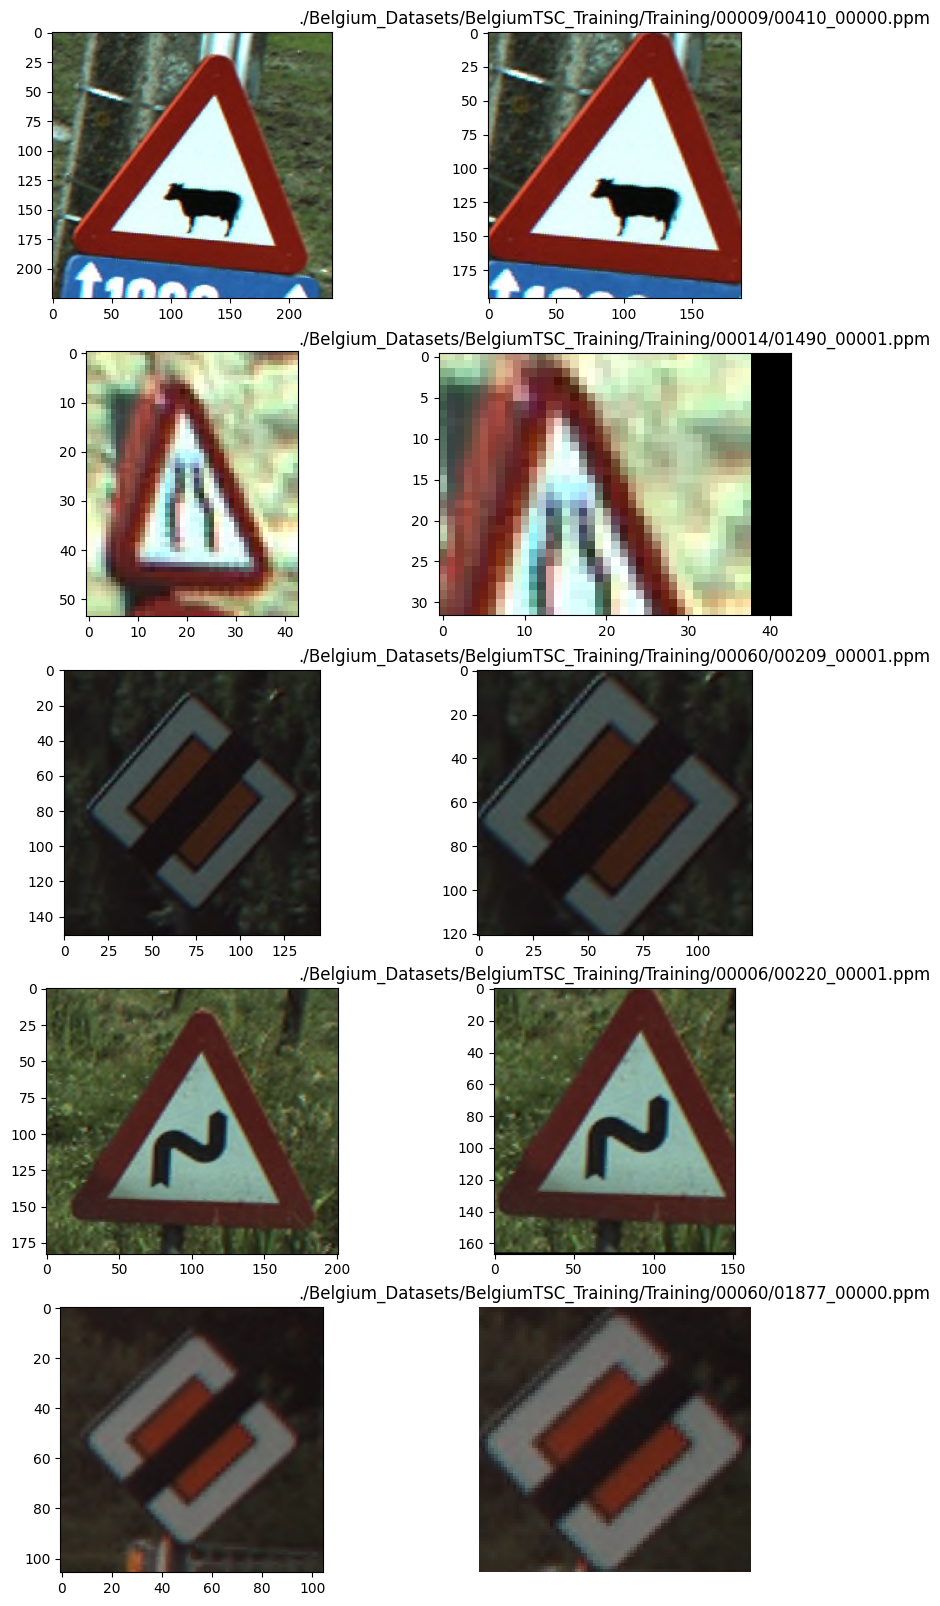

In [13]:
showExamples(df)

In [22]:
# Load pre-trained  model with random weights
model = Sequential([
    InputLayer(input_shape=(resize_x,resize_y,3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128,activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_of_classes, activation='softmax') 
])

# Display the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dense_3 (Dense)             (None, 128)              

In [23]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
print(df["ClassId"].dtype)
# Assuming 'df' is your DataFrame
df["ClassId"] = df["ClassId"].astype('int64')
df["ClassId"] = df["ClassId"].astype('str')
print(df["ClassId"].dtype)

object
object


In [25]:
df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,Rotate,length,height,ClassId
0,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,109.0,111.0,9.0,9.0,99.0,101.0,0,90.0,92.0,13
1,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,97.0,56.0,8.0,5.0,89.0,50.0,0,81.0,45.0,55
2,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,81.0,84.0,7.0,7.0,74.0,77.0,0,67.0,70.0,13
3,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,121.0,124.0,10.0,10.0,111.0,114.0,0,101.0,104.0,23
4,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,72.0,67.0,6.0,6.0,65.0,61.0,0,59.0,55.0,43


In [26]:
class CustomImageDataGenerator(ImageDataGenerator):
    def __init__(self,dataframe, x1_col, y1_col, x2_col, y2_col, Path,directory, preprocessing_function=None, **kwargs):
        super().__init__(preprocessing_function=preprocessing_function, **kwargs)
        self.dataframe=dataframe
        self.directory = directory
        self.x1_col = x1_col
        self.y1_col = y1_col
        self.x2_col = x2_col
        self.y2_col = y2_col
        self.Path   = Path
        

    def flow_from_dataframe(self, *args, **kwargs):
        generator = super().flow_from_dataframe(*args, **kwargs)
        generator.Path = self.Path
        return generator

    def __getitem__(self, index):
        # Override the __getitem__ method to load and preprocess images based on coordinates
        current_batch = super().__getitem__(index)
        
        # Load original images and preprocess based on coordinates
        for i in range(len(current_batch[0])):
            x1 = self.dataframe[self.x1_col].iloc[index * self.batch_size + i]
            y1 = self.dataframe[self.y1_col].iloc[index * self.batch_size + i]
            x2 = self.dataframe[self.x2_col].iloc[index * self.batch_size + i]
            y2 = self.dataframe[self.y2_col].iloc[index * self.batch_size + i]
            original_image_path = self.dataframe[self.Path].iloc[index * self.batch_size + i]
            original_image = Image.open(directory+original_image_path)
            region = original_image.crop((x1, y1, x2, y2))
            region_array = np.array(region)
            
            # Apply preprocessing_function if specified
            if self.preprocessing_function:
                region_array = self.preprocessing_function(region_array)

            current_batch[0][i] = region_array

        return current_batch

In [27]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [28]:
df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,Rotate,length,height,ClassId
0,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,67.0,51.0,6.0,5.0,61.0,46.0,0,55.0,41.0,24
1,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,160.0,73.0,13.0,6.0,146.0,67.0,0,133.0,61.0,46
2,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,79.0,75.0,7.0,6.0,72.0,68.0,0,65.0,62.0,39
3,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,309.0,202.0,26.0,17.0,282.0,185.0,0,256.0,168.0,44
4,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,50.0,50.0,5.0,5.0,44.0,44.0,0,39.0,39.0,5


In [29]:
datagen  = CustomImageDataGenerator(
    df,
    "Roi.X1",
    "Roi.Y1",
    "Roi.X2",
    "Roi.Y2",
    "Filename",
    directory,
    rescale=1./255,  
    rotation_range=20,  
    width_shift_range=0.2,  
    height_shift_range=0.2,
    shear_range=0.2,  
    zoom_range=0.2,  
    horizontal_flip=True,  
    fill_mode='nearest'  ,
    validation_split = 0.2,
    samplewise_center=True
)

train_generator = datagen.flow_from_dataframe(
     df,
    x_col='Filename',
    y_col="ClassId",
    target_size=(resize_x,resize_y),
    batch_size=32,
     directory=directory,
    class_mode='sparse',
    subset='training'
)

val_generator = datagen.flow_from_dataframe(
  df,
    x_col='Filename',
    y_col="ClassId",
    target_size=(resize_x,resize_y),
    batch_size=32,
     directory=directory,
    class_mode='sparse',
    subset='validation'
)

Found 18600 validated image filenames belonging to 62 classes.
Found 4650 validated image filenames belonging to 62 classes.


In [30]:
starting_time = time.time()

history = model.fit( train_generator,
    steps_per_epoch=len(train_generator),
    epochs=Epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

ending_time = time.time()
total_time = ending_time - starting_time
total_time/=60

print("Time taken fit : ",total_time," min")

Epoch 1/50
 46/582 [=>............................] - ETA: 21s - loss: 4.1076 - accuracy: 0.0177

KeyboardInterrupt: 

In [165]:
# #Saving the model
# model.save("MobileNetV3-Belgium")

In [175]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

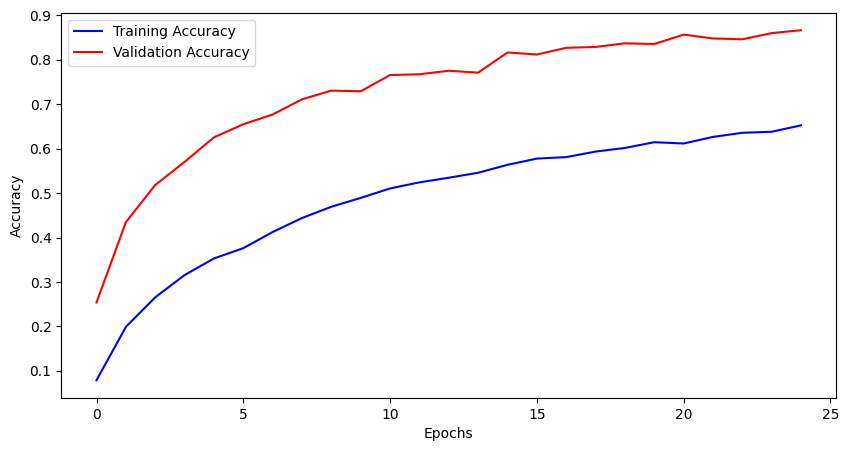

In [176]:
epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,training_accuracy,color="blue",label="Training Accuracy")
plt.plot(epochs,validation_accuracy,color="red",label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

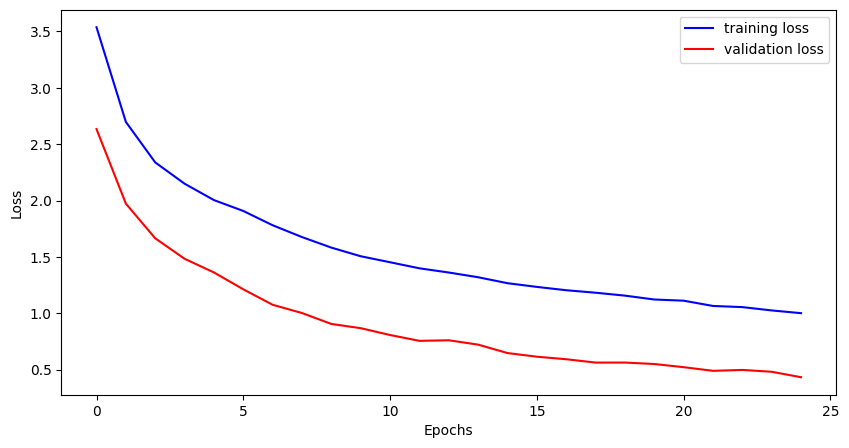

In [177]:
epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,loss,color="blue",label="training loss")
plt.plot(epochs,val_loss,color="red",label="validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

 ***Test Image Classification and Accuracy Calculation***

In [178]:
# #Loading weights into CNN model 
# model = tf.keras.models.load_model("CNN_Model_SimpleLayered_Belgium")

In [179]:
df_test=[[]]
df_test=pd.DataFrame(df)
for i in trainclasses:
    path = "./Belgium_Datasets/BelgiumTSC_Testing/Testing/"+i+"/GT-"+i+".csv"
    df1 = pd.read_csv(path,sep=';')
    df1['Filename']="./Belgium_Datasets/BelgiumTSC_Testing/Testing/"+i+'/'+df1["Filename"]
    df=pd.concat([df_test,df1],ignore_index=True)
print("Number of Test Images are ", len(df_test))
df_test['Rotate']=0
df_test=df_test.dropna()
df_test.head()

Number of Test Images are  23355


,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,Rotate,length,height,ClassId
0,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,109.0,111.0,9.0,9.0,99.0,101.0,0,90.0,92.0,13
1,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,97.0,56.0,8.0,5.0,89.0,50.0,0,81.0,45.0,55
2,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,81.0,84.0,7.0,7.0,74.0,77.0,0,67.0,70.0,13
3,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,121.0,124.0,10.0,10.0,111.0,114.0,0,101.0,104.0,23
4,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,72.0,67.0,6.0,6.0,65.0,61.0,0,59.0,55.0,43


Total Training Examples :  23250


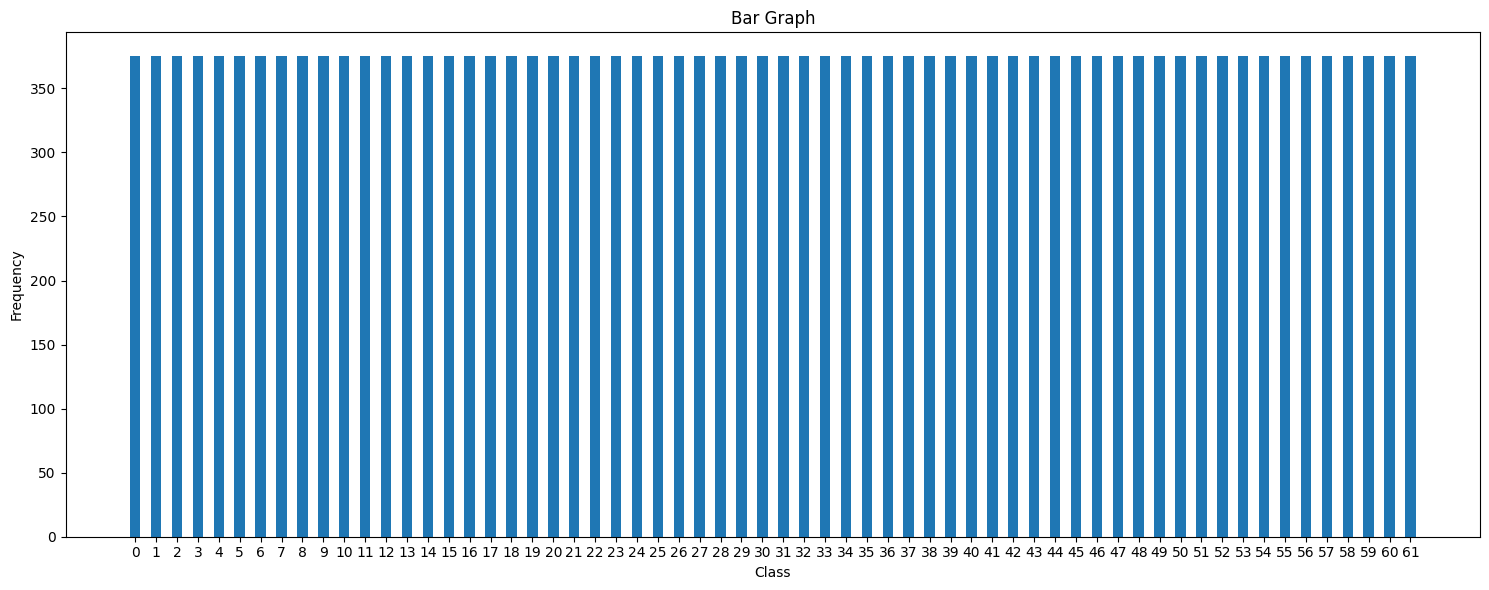

Total Training Examples :  23250


In [180]:
viewStatistics(df_test)
print("Total Training Examples : ",len(df_test))

In [181]:
# showExamples(df_test)
df_test.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,Rotate,length,height
count,23250.000000,23250.000000,23250.000000,23250.000000,23250.000000,23250.000000,23250.0,23250.000000,23250.000000
mean,131.183785,118.670753,11.034624,10.030065,119.645849,108.128215,0.0,108.611226,98.098151
std,67.697766,62.596065,5.577267,5.115005,62.110673,57.494516,0.0,56.549407,52.401856
min,22.000000,20.000000,5.000000,5.000000,16.000000,14.000000,0.0,11.000000,9.000000
25%,86.000000,75.000000,7.000000,6.000000,79.000000,68.000000,0.0,72.000000,62.000000
50%,116.000000,106.000000,10.000000,9.000000,105.000000,96.000000,0.0,95.000000,87.000000
75%,157.000000,142.000000,13.000000,12.000000,144.000000,129.000000,0.0,131.000000,117.000000
max,724.000000,529.000000,60.000000,44.000000,664.000000,484.000000,0.0,604.000000,440.000000


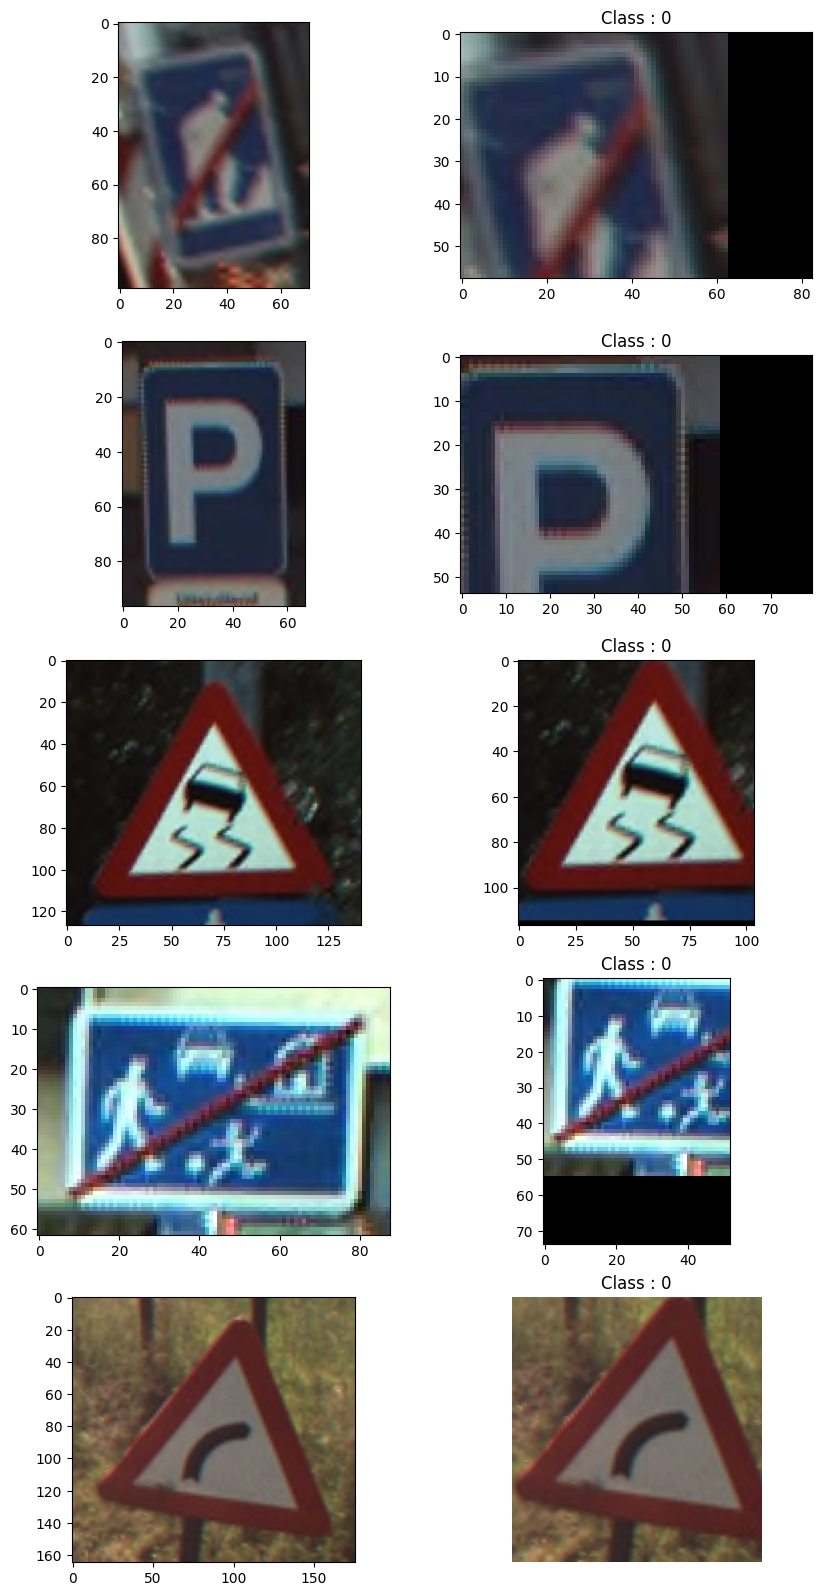

In [182]:
showTestExamples(df_test)

In [183]:
test_datagen = CustomImageDataGenerator(df_test,"Roi.X1",
                                   "Roi.Y1",
                                   "Roi.X2",
                                   "Roi.Y2",
                                   "Filename",
                                   directory,
                                   rescale=1./255)  # You can add other preprocessing options as needed

batch_size = 32  # Adjust based on your requirements

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='Filename',
    y_col='ClassId',
    directory=directory,
    target_size=(resize_x, resize_y),  # Adjust based on your model's input size
    batch_size=batch_size,
    class_mode='sparse',  # Adjust based on your task
    shuffle=False  # Set to False for testing to maintain the order
)

Found 23250 validated image filenames belonging to 62 classes.


In [184]:
y_test = test_generator.classes
pred = model.predict(test_generator)
y_pred = np.argmax(pred, axis=1)

727/727 [==============================] - 10s 14ms/step


In [185]:
confusion = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = np.sum(np.diag(confusion)) / np.sum(confusion)
print("Total Accuracy: ", accuracy*100)

# Calculate precision, recall, and F1-score
classification_rep = classification_report(y_test, y_pred, labels=np.unique(y_pred))

# Print the results
print("\nConfusion Matrix:\n", confusion)


lines = classification_rep.split('\n')
data = []

for line in lines[2:-5]:  # Exclude header and footer lines
    row_data = line.split()
    if len(row_data) > 0:
        class_name = row_data[0]
        precision = float(row_data[1])
        recall = float(row_data[2])
        f1_score = float(row_data[3])
        support = int(row_data[4])
        data.append([class_name, precision, recall, f1_score, support])

# Create a DataFrame
report = pd.DataFrame(data, columns=['Class', 'Precision', 'Recall', 'F1-Score', 'Support'])
# Print the DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print("\n\n\n Summarizing the results : ")
report

Total Accuracy:  42.43010752688172

Confusion Matrix:
 [[259   0   0 ...   0   0   0]
 [ 67  94  11 ...   0   4   0]
 [  0   0  36 ...  36   0   0]
 ...
 [  0   0   0 ... 120   0   0]
 [  0   0   0 ...   0 229   0]
 [  0   0   0 ...   0   0   0]]



 Summarizing the results : 


,Class,Precision,Recall,F1-Score,Support
0,0,0.79,0.69,0.74,375
1,1,1.00,0.25,0.40,375
2,2,0.40,0.10,0.16,375
3,3,0.99,0.73,0.84,375
4,4,0.10,0.05,0.06,375
5,5,0.41,0.44,0.43,375
6,6,0.15,0.92,0.25,375
7,7,0.00,0.00,0.00,375
8,8,0.00,0.00,0.00,375
9,9,1.00,0.22,0.36,375


Original Value :  318.0
1/1 [==============================] - 0s 52ms/step
Predicted Value :  6


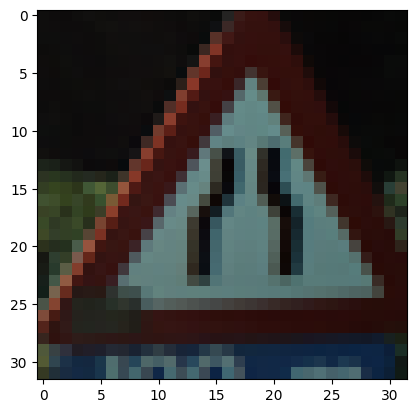

In [186]:
# Testing one Random Image from test data 
test_length = len(df_test)
select_row=random.randint(0,test_length-1)
row = df_test.iloc[select_row]
print("Original Value : ",df_test.iloc[select_row,6])
img = Image.open(directory+row.iloc[0])
img = img.crop((row.iloc[3],row.iloc[4],row.iloc[5],row.iloc[6]))
img = img.resize((resize_x,resize_y))
plt.imshow(img)
img  = np.array(img)
img  = tf.convert_to_tensor(img,dtype=float)
img = img/255.0
img = tf.expand_dims(img, axis=0)
probability = model.predict(img)
value = get_max_index(probability[0])
print("Predicted Value : ",value)

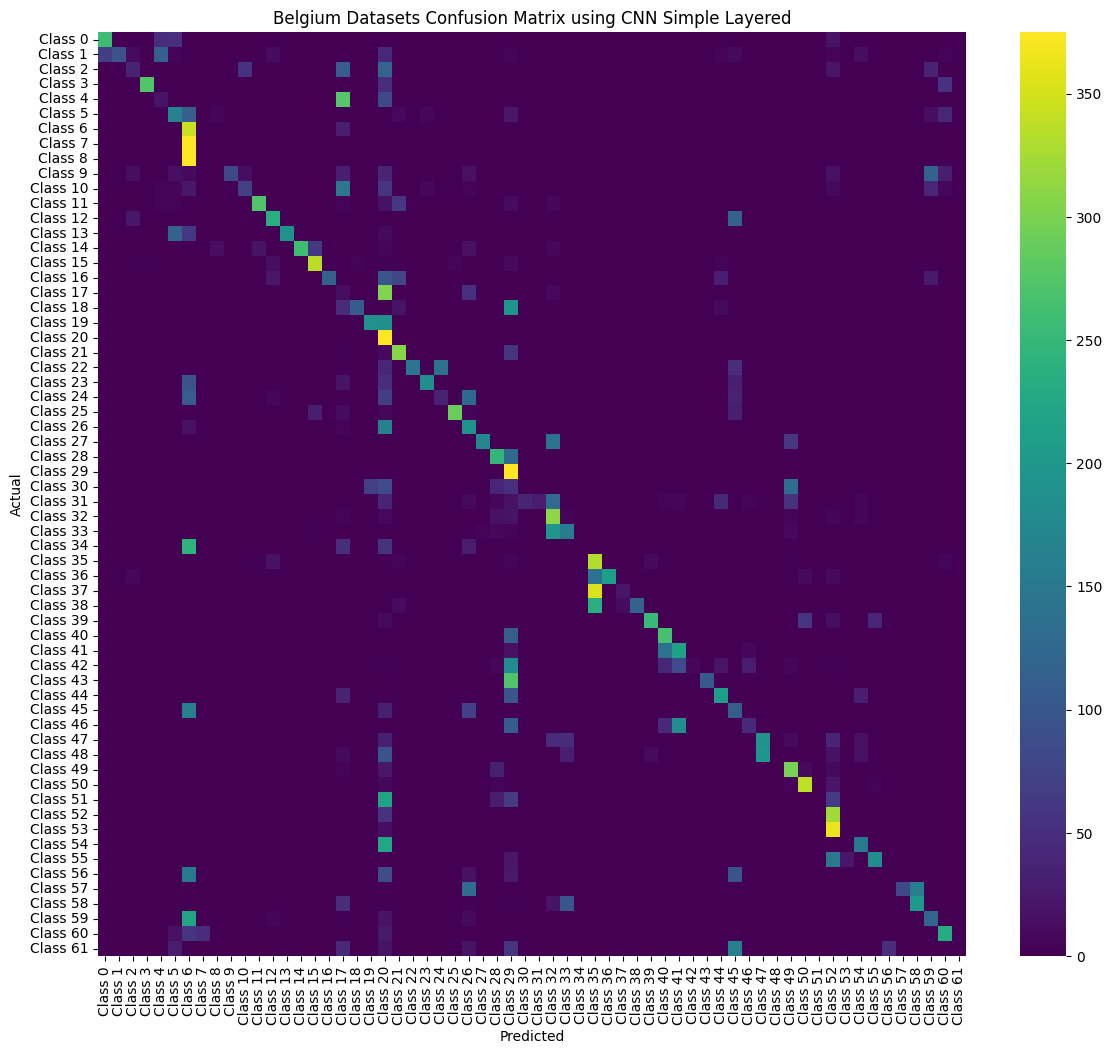

In [187]:
class_names = []
for i in range(num_of_classes):
    class_names.append("Class "+str(i))
# Create a heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(confusion, annot=False, cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Belgium Datasets Confusion Matrix using CNN Simple Layered')
plt.show()